## Reproducing landmark matching

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd gdrive/MyDrive/deanonymization_pet_reproducibility/notebooks

/content/gdrive/MyDrive/deanonymization_pet_reproducibility/notebooks


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

In [ ]:
# pet_matrix = load_all_batches("../data/nearest_neigh_landmarks_repositioning", fold_id=fold_id)
pet_matrix = np.load("../data/nearest_neigh_landmarks_repositioning/distances_fold0_aligned.npy")
pet_matrix.shape

(103, 112)

In [ ]:
# get pet and ct file names
pet_landmarks_path = glob.glob('../data/landmarks/fold_0/*pet.npy')
ct_landmarks_path =  glob.glob('../data/landmarks/fold_0/*ct.npy')

assert len(pet_landmarks_path)  == pet_matrix.shape[0]
assert len(ct_landmarks_path) == pet_matrix.shape[1]

In [ ]:
pet_names = np.array([s.split('PETCT_')[1].split('_pet')[0] for s in pet_landmarks_path])
ct_names = np.array([s.split('PETCT_')[1].split('_ct')[0] for s in ct_landmarks_path])

In [ ]:
def compute_accuracy1(pet_matrix, ct_names, pet_names):
    closest_ct_idx = np.argmin(pet_matrix, axis=1)
    ct_pred = ct_names[closest_ct_idx]

    return np.sum(ct_pred == pet_names)/len(pet_names)

In [ ]:
compute_accuracy1(pet_matrix=pet_matrix,
                  ct_names=ct_names,
                  pet_names=pet_names)

0.30097087378640774

In [ ]:
def compute_accuracy_n(pet_matrix, ct_names, pet_names, n=10):
    closest_ct_idx = np.argsort(pet_matrix, axis=1)[:, :n]
    ct_pred = ct_names[closest_ct_idx]

    # good predictions
    good_pred = [pet_names[i] in ct_pred[i,:] for i in range(len(pet_names))]
    return np.sum(good_pred)/len(pet_names)

In [ ]:
compute_accuracy_n(pet_matrix, ct_names, pet_names, n=5)

0.6407766990291263

## Without point cloud alignment

In [ ]:
# get pet and ct file names
acc_types = [1, 3, 5, 10, 15]
columns = [f"Accuracy{acc}" for acc in acc_types]
df_accuracy = pd.DataFrame(columns=columns, index=np.arange(5))
for fold in range(5):
    print(f"Processing fold {fold}")
    pet_landmarks_path = glob.glob(f'../data/landmarks/fold_{fold}/*pet.npy')
    ct_landmarks_path =  glob.glob(f'../data/landmarks/fold_{fold}/*ct.npy')

    pet_names = np.array([s.split('PETCT_')[1].split('_pet')[0] for s in pet_landmarks_path])
    ct_names = np.array([s.split('PETCT_')[1].split('_ct')[0] for s in ct_landmarks_path])
    distances = np.load(f"../data/nearest_neigh_landmarks_repositioning/distances_fold{fold}.npy")

    for acc_type, col in zip(acc_types, columns):
        df_accuracy.loc[fold, col] = compute_accuracy_n(pet_matrix=distances,
                                                        ct_names=ct_names,
                                                        pet_names=pet_names,
                                                        n=acc_type)

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


In [ ]:
df_accuracy

,Accuracy1,Accuracy3,Accuracy5,Accuracy10,Accuracy15
0,0.76699,0.893204,0.893204,0.92233,0.92233
1,0.855769,0.942308,0.951923,0.971154,0.980769
2,0.71,0.87,0.91,0.95,0.98
3,0.8,0.927273,0.954545,0.963636,0.972727
4,0.790476,0.914286,0.914286,0.92381,0.942857


In [ ]:
df_accuracy.mean(0)

Accuracy1     0.784647
Accuracy3     0.909414
Accuracy5     0.924792
Accuracy10    0.946186
Accuracy15    0.959737
dtype: float64

In [ ]:
df_accuracy.std(0)

Accuracy1     0.052943
Accuracy3     0.028464
Accuracy5     0.027149
Accuracy10    0.022429
Accuracy15    0.026009
dtype: float64

In [ ]:
81.6/44.8

1.8214285714285714

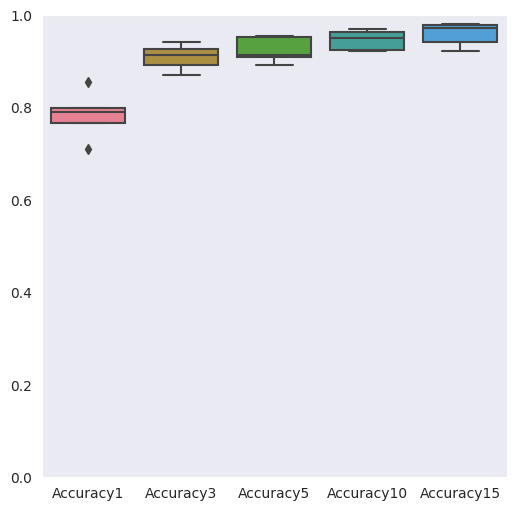

In [ ]:
sns.set_style('dark')
palette = sns.set_palette("husl")
plt.figure(figsize=(6,6))
sns.boxplot(data=df_accuracy, palette=palette)
plt.ylim((0,1))
plt.savefig("../docs/landmark_placement/landmark_matching_all_folds_without_alignment.png", dpi=300)
plt.show()

In [ ]:
compute_accuracy1(pet_matrix=distances,
                  ct_names=ct_names,
                  pet_names=pet_names)

0.7904761904761904

In [ ]:
compute_accuracy_n(distances, ct_names, pet_names, n=10)

0.9238095238095239

## With alignment

In [ ]:
# get pet and ct file names
acc_types = [1, 3, 5, 10, 15]
columns = [f"Accuracy{acc}" for acc in acc_types]
df_accuracy = pd.DataFrame(columns=columns, index=np.arange(5))
for fold in range(5):
    print(f"Processing fold {fold}")
    pet_landmarks_path = glob.glob(f'../data/landmarks/fold_{fold}/*pet.npy')
    ct_landmarks_path =  glob.glob(f'../data/landmarks/fold_{fold}/*ct.npy')

    pet_names = np.array([s.split('PETCT_')[1].split('_pet')[0] for s in pet_landmarks_path])
    ct_names = np.array([s.split('PETCT_')[1].split('_ct')[0] for s in ct_landmarks_path])
    distances = np.load(f"../data/nearest_neigh_landmarks_repositioning/distances_fold{fold}_aligned.npy")

    for acc_type, col in zip(acc_types, columns):
        df_accuracy.loc[fold, col] = compute_accuracy_n(pet_matrix=distances,
                                                        ct_names=ct_names,
                                                        pet_names=pet_names,
                                                        n=acc_type)

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


In [ ]:
df_accuracy

,Accuracy1,Accuracy3,Accuracy5,Accuracy10,Accuracy15
0,0.300971,0.543689,0.640777,0.805825,0.834951
1,0.394231,0.557692,0.663462,0.759615,0.836538
2,0.21,0.34,0.43,0.63,0.69
3,0.354545,0.545455,0.609091,0.754545,0.809091
4,0.333333,0.514286,0.580952,0.657143,0.72381


In [ ]:
df_accuracy.mean(0)

Accuracy1     0.318616
Accuracy3     0.500224
Accuracy5     0.584856
Accuracy10    0.721426
Accuracy15    0.778878
dtype: float64

In [ ]:
df_accuracy.std(0)

Accuracy1     0.069523
Accuracy3     0.090977
Accuracy5     0.092045
Accuracy10    0.074447
Accuracy15    0.067664
dtype: float64

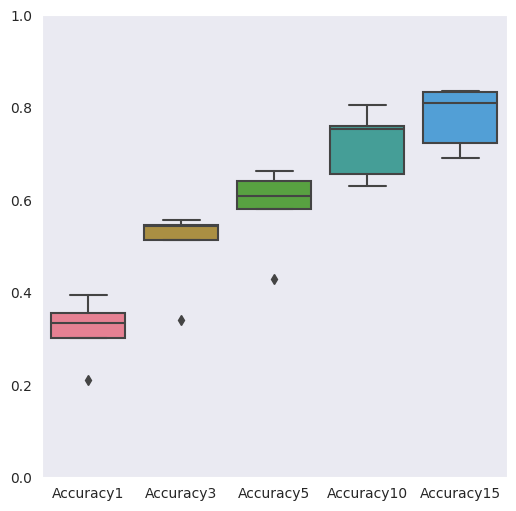

In [ ]:
sns.set_style('dark')
palette = sns.set_palette("husl")
plt.figure(figsize=(6,6))
sns.boxplot(data=df_accuracy, palette=palette)
plt.ylim((0,1))
plt.savefig("../docs/landmark_placement/landmark_matching_all_folds_aligned.png", dpi=300)
plt.show()